# King County advanced EDA

This notebook follows some advanced exploratory data analaysis ideas outlined in Michael P. Notters ["Advanced exploratory data analysis (EDA)"](https://miykael.github.io/blog/2022/advanced_eda/) and is used as an practice approach to improve my EDA.

It uses some tools to get a quick handle on tabular data, but is in no way a complete approach.

In this notebook we first look int the structure of our data, followed by the quality and content.

1. **Structure**: general exploration of shape, data types, etc.
2. **Quality**: informaton about missing data, duplicate entries, outliers (unwanted entries)
3. **Content**: more in-depth analysis to understand our feature values and how they relate to each other


Beforehand however we need to load the data. For this purpose we are using pandas.

In [307]:
import pandas as pd

# load the data into a pandas data frame using the pd.read_csv method
df = pd.read_csv('data/King_County_House_prices_dataset.csv')

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### 1. Structure Analysis

As mentioned, before we are looking into the quality and Content of our data, we start out with a very basic analysis of the structure.
The first step is to find out how many observations and features we have.

In [308]:
# display size of the dataframe
df.shape

(21597, 21)

With this we know that our dataset contains roughl 21k observations and 21 column features and we shortly have a look at the column names to get a first glance at the features.

In [309]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Next, we want to understand with how many different data types we are dealing.

In [310]:
# display how often the different data types are represented within our dataset
df.dtypes.value_counts()

int64      11
float64     8
object      2
dtype: int64

#### 1.1 Structure of non-numerical features

We are dealing with numerical data (int and float) as well as with 2 non-numerical features. We start by looking into the 2 non-numerical columns in our dataset.

In [311]:
# display the first 5 entries of our non-numerical features
df.select_dtypes(exclude='number').head()

,date,sqft_basement
0,10/13/2014,0.0
1,12/9/2014,400.0
2,2/25/2015,0.0
3,12/9/2014,910.0
4,2/18/2015,0.0


Even though sqft_basement is a numerical feature it was stored as a non-numerical one. Quite similar with date, which is ideally stored as a dateformat for further analysis.
Thus, in the next step we look more in detail into this two features and try to convert them to their ideal data type. The direct convertion using .astype is not working as currently there are some values existing, which cannot be converted automatically.

Thhus, in order to check if the sqft_basement contains only numerical data and can be converted, we are extracting the individual values of the sqft_basement series and parsing it into a list.

In [312]:
# create a lit of unique values available in the sqft_basement series
value_list = set(df['sqft_basement'].values)

# check for values not containing numbers and the decimal seperator
for element in value_list:
    if re.search('[^0123456789.]', element):
        print(element)

?


Some observations contain a question mark instead of a number. As we cannot convert the ? into a float or int, we investigate first how many observations hold this value. Based on this, we can either drop all impacted observations or impede the data with a different value.

In [313]:
len(df[df['sqft_basement'] == '?'])

454

With 454 entries the amount is to high as to drop the observations. Accordingly, we impede the missing data. We could either choose the median or mean to fill in. However, in this case, we treat the missing value as not having a basement size and fill it with 0 instead.

In [314]:
# replace the question mark with 0.0
df['sqft_basement'] = df['sqft_basement'].replace('?', 0.0)

# double check the amount of observations containing a question mark
len(df[df['sqft_basement'] == '?'])

0

From looking at the column names earlier on, we saw that we have multiple columns describing the sqft size of property/ground. Thus, we shortly check if we are dealing with int or float values for the other types and try to convert the sqft_basement in accordance.

In [315]:
# check the data type of the sqft features
df[['sqft_living', 'sqft_lot', 'sqft_above']].dtypes

sqft_living    int64
sqft_lot       int64
sqft_above     int64
dtype: object

In [316]:
# check the first entries of the sqft_basement again
df['sqft_basement'].head()

0      0.0
1    400.0
2      0.0
3    910.0
4      0.0
Name: sqft_basement, dtype: object

As we can see we are dealing with float like values which are currently cast as a string. These values cannot automatically cast into int values due due the decimal values.


In [317]:
# convert the object type values into float and afterwards to int
df['sqft_basement'] = df['sqft_basement'].astype('float').astype('int')
df['sqft_basement'].dtypes

dtype('int64')

As a last action for the object type data feature, we are now casting the date column into a date type, so that we can use it later on for further visualisations and data analysis.

In [318]:
# convert the date column into a date type object
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

# double check the data types of our data frame
df.dtypes.value_counts()

int64             12
float64            8
datetime64[ns]     1
dtype: int64

With this we would actually move to look a bit further into the descriptive statistics of the non numerical values. However, as we have casted them now to different data types (int and date time respectively), we move now to the date feature and afterwards the numerical data types.

#### 1.2 Structure of date time feature

For this feature we are only shortly checking the range to understand with which time period our data set is dealing.

In [319]:
start = df.date.min()
end = df.date.max()

print(f'start date: {start.date()}')
print(f'end date: {end.date()}')

start date: 2014-05-02
end date: 2015-05-27


#### 1.3 Structure of numerical features

Next, we take a closer look at the numerical columns. We investigate how many unique values the individual features have. This gives us some insights about the number of binary (2), ordinal (3 to 10) and continuous (more than 10) features in the dataset.

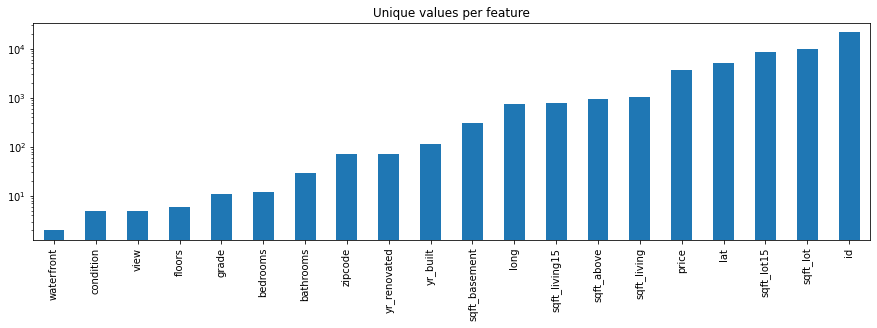

In [320]:
# get the amount of unique values per numerical feature and sort them in ascending order
unique_values = df.select_dtypes(include="number").nunique().sort_values()

# plot the unique values to visualise the amount of unique values
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

Before we conclude this section, we are using the .describe method to look into the basic descriptive statistics and get some insights about min, max, median, mean, percentiles, standard deviation and count.

In [321]:
df.select_dtypes(include="number").describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,285.716581,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,439.819830,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


#### 1.4 Conclusion of structural investigation

With this basic structural investigation we have a slightly better understanding of our data frame and already "corrected" some of the data types. We got a rough estimation about the values (unique features) our data frame represents as well as with how many observations and which time frame we are dealing.

df.describe(), df.info() are helpful methods to get a insight directly in the beginning, but looking at the different data types seperately helps to understand to deal with the data set later on.

### 2. Quality Investigation

In this part of the notebook we are investigating the overall quality of our data. This mean we are looking for duplicates, missing values and unwanted entries or recording errors. This might also concern outliers which could have a negative impact when using the data later on for predictive modelling.

#### 2.1 Duplicates

Here we look for entries which represent the same sample point in our data set. This might come into place, by accidentially adding an observation multiple times, while extracting the data from a SQL database or so on. While looking for duplicates we need to make sure that we ignore potential indexes (which might be unique even thought the rest of the observation is a duplicate)

In [322]:
# Check number of duplicates while ignoring the index feature
num_duplicates = df.drop(labels=["id"], axis=1).duplicated().sum()
print(f"There seems to be {num_duplicates} duplicates in your database.")

There seems to be 0 duplicates in your database.


While we seem not to have any full duplicates within our data set, but iif we had duplicates, we simply could use the .drop_duplicates() method based on the relevant columns to drop duplicates from our dataset. 

As we do not have them, this step is not necessary, but we still look to see if some of the ids appear more than once.

In [323]:
id_counts = df['id'].value_counts()
id_counts.value_counts()

1    21244
2      175
3        1
Name: id, dtype: int64

We seem to have 175 ids which appear twice and one id that even appears three times within our dataset. While they are not full duplicates, it might still be worth investigating. As we only have one year worth of data, the appearance of the identical ids mights still be a mistake.

In [324]:
# create a boolean matrix that checks for 
duplicate_mask = id_counts >= 2

In [325]:
# use the mask to extract the id index where we have more than 1 entries
duplicate_ids = id_counts.index[duplicate_mask]
duplicate_ids = duplicate_ids.values.tolist()

# look at the ids which are contained in multiple observations
df[df['id'].isin(duplicate_ids)].sort_values('id')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2495,1000102,2015-04-22,300000.0,6,3.00,2400,9373,2.0,0.0,0.0,...,7,2400,0,1991,0.0,98002,47.3262,-122.214,2060,7316
2494,1000102,2014-09-16,280000.0,6,3.00,2400,9373,2.0,NaN,0.0,...,7,2400,0,1991,0.0,98002,47.3262,-122.214,2060,7316
16800,7200179,2014-10-16,150000.0,2,1.00,840,12750,1.0,0.0,0.0,...,6,840,0,1925,0.0,98055,47.4840,-122.211,1480,6969
16801,7200179,2015-04-24,175000.0,2,1.00,840,12750,1.0,0.0,0.0,...,6,840,0,1925,NaN,98055,47.4840,-122.211,1480,6969
11422,109200390,2014-10-20,250000.0,3,1.75,1480,3900,1.0,0.0,0.0,...,7,1480,0,1980,0.0,98023,47.2977,-122.367,1830,6956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6339,9828200460,2014-06-27,260000.0,2,1.00,700,4800,1.0,0.0,0.0,...,7,700,0,1922,0.0,98122,47.6147,-122.300,1440,4800
15186,9834200305,2015-02-10,615000.0,3,1.00,1790,3876,1.5,0.0,0.0,...,7,1090,700,1904,0.0,98144,47.5750,-122.288,1360,4080
15185,9834200305,2014-07-16,350000.0,3,1.00,1790,3876,1.5,0.0,0.0,...,7,1090,0,1904,0.0,98144,47.5750,-122.288,1360,4080
1084,9834200885,2014-07-17,360000.0,4,2.50,2080,4080,1.0,0.0,0.0,...,7,1040,1040,1962,0.0,98144,47.5720,-122.290,1340,4080


It seems that the entries are not duplicates, but that these rather indicate houses which have been resold within a short amount of time. However, while they are not duplicate the older entry is not that interesting for us and does not represent the latest information on the property we have. Therefore, the older entry will be dropped from our data set to make sure that we only keep the most relevant information.

In [326]:
# sort the data frame based on id and date
df.sort_values(['id', 'date'], inplace=True)

# drop the first entry
df = df.drop_duplicates(subset='id', keep='last')

# double check if all duplicate ids are now removed
id_counts = df['id'].value_counts()
id_counts.value_counts()

1    21420
Name: id, dtype: int64

With this we have checked for duplicates and made sure that we drop out dated data from our data set. In the next step we look into missing values and how to treat them in the context of this data set.

#### 2.2 Missing values

Missing values can be challenging, especially if we want to create a predictive model out of our data set. Thus, while it is normal to have some missing values, we need to identify how many observations have missing values and we have specific gaps in our data and how to treat them.

##### 2.2.1 Missing values per observation

First, we visualise missing values on sample level. This can be done by visualising the .isna() result.

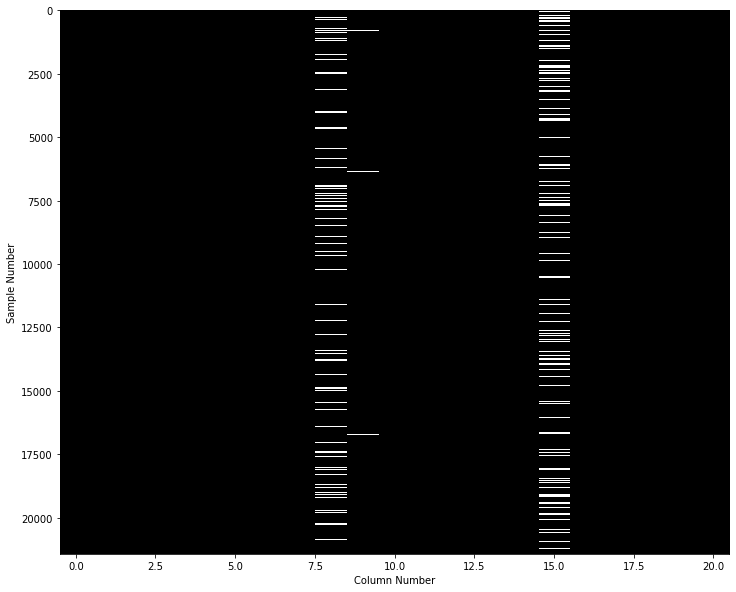

In [327]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");

This graph show the observations on the y-axis and the columns on the x-axis. With this visualisation we can easily identifiy that only two columns contain a higher extent of missing values. Besides that only one additional feature seems to hold a handful of missing values. The rest of the data seems to be complete.

However, this plot (or any method looking for null / None values) is not able to identify content that indicates missing values, but is not treated by the system as such (e.g. value not given, missing value). This was for example the case with the question marks in the sqft_basement feature. While the data was missing and not given, the question mark is not a NaN value that can be recognized by the built-in methods.

As our data is quiet consistent we will see if we can finde logical ways to impede the missing values. If we had big gaps and some observations with many missing values, we could also drop some observations all together using the .dropna() method. By defining a threshold withhin the method (thresh), we can define that if a certain amount of values are missing for a observation to drop it.

```py
# example code for how to drop observations that contain more than 20% missing values
df = df.dropna(thresh=df.shape[1] * 0.80, axis=0).reset_index(drop=True)
```

2.2.2. Missing values per feature

Next, we look at the number of missing values per feature. We can use pandas to find out what the ratio of missing values is per feature and visualise it.


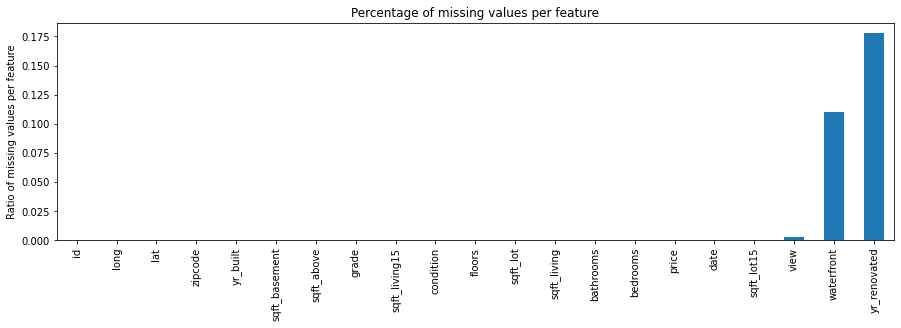

In [328]:
# create a boolean mask for the whole data frame, calculate the mean of missing vaues per feature,
# sort the values in ascending order and plot it
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

We can see that most of our features are complete and do not contain any missing values. TAs these features are also relevant for our prediction and stakeholder request, we are not going to drop these features altogher, but impude the missing values in the next step.

However, if we wanted to drop some features altogether because they consist to a very high amount out of missing values, we could do this using the following lines of code:

```py
# example code for how to drop features that contain more than 15% missing values
df = df.dropna(thresh=df.shape[0] * 0.85, axis=1)
```

##### 2.2.3 Impude missing values

Before we can impude the data, we need to have a short look at the values in the respective feature columns and their meaning.

In [329]:
df[['view', 'waterfront', 'yr_renovated']].describe()

,view,waterfront,yr_renovated
count,21357.000000,19067.000000,17607.000000
mean,0.234677,0.007657,83.890101
std,0.766459,0.087172,400.534473
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,4.000000,1.000000,2015.000000


Based on this overview, we can replace the NaN values in the waterfront feature with the mode of this column. This means that we are replacing the NaNs with a 0, indicating that this house is not placed at the waterfront. As this is a relevant feature for our stakeholder, we rather treat missing data in this column as "not at the waterfront" than recommending a wrong house.

In regards to the yr_renovated feature: as we are interested in the effect of the house age in regards to the housing price, the yr_renovated column might give interesting insights in this topic and we will not remove it. However, we also have many 0 values in there, which likely represent a non-renovated status and for this EDA we will interpret missing data in this column also as not renovated and replace it with a 0.

The same will be done for the view, which anyhow contains only minor missing values.

In [342]:
# replacing all NaNs with 0, which is the most common entry as well as the indication that this feature is not fullfilled.
df['view'] = df['view'].fillna(df['view'].mode()[0])
df['waterfront'] = df['waterfront'].fillna(df['waterfront'].mode()[0])
df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_renovated'].mode()[0])

# double check missing values
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

2.3. Unwanted entries and recording errors

Unwanted entries or recording errors can be another challenging part within a data set and It is important to identify these observations and to differentiate them from outliers. While both can cause challenges, outliers are "true" observations, while recording errors are simple that... errors.

2.3.1. Numerical features

For numerical values, we can again use pandas .plot() function. With the following parameters are we able to set up the plot accordingly.

```lw=0```: linewidth = 0, means no lines  
```marker="."```: change the marker from a line to a '.'  
```subplots=True```: each feature is plotted in a separate subplot  
```layout=(-1, 4)```: defines the rows and columns for the plot. -1 means “as many as needed”  
```figsize=(15, 30), markersize=1```:  have a figure height of roughly the number of features and adjust the markersize accordingly


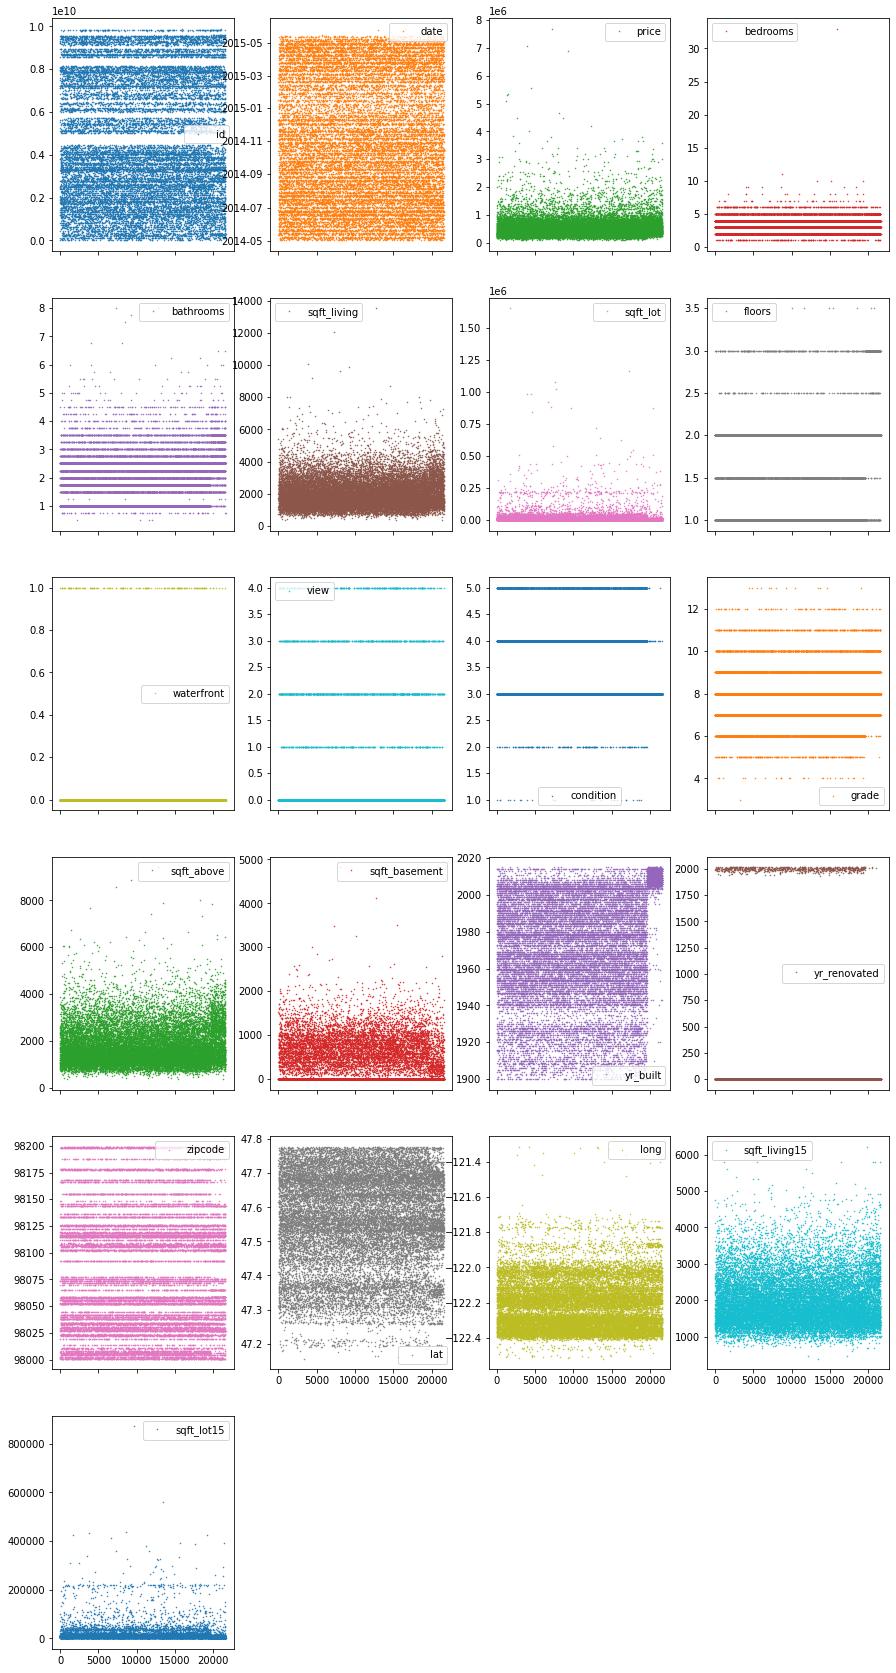

In [343]:
df.plot(lw=0, marker=".", subplots=True, layout=(-1, 4), figsize=(15, 30), markersize=1);


Each point in this figure is a sample (i.e. a row) in our dataset and each subplot represents a different feature. The y-axis shows the feature value, while the x-axis is the sample index. These kind of plots can give you a lot of ideas for data cleaning and EDA. Usually it makes sense to invest as much time as needed until your happy with the output of this visualization.